In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/')
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import *
from src.model import *
from data.MnistSet import *
from time import sleep
from tqdm import tqdm

### Preparamos los datos de entreno y test

In [2]:
batch_size = 32

In [3]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=batch_size, num_workers=4)

In [4]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=batch_size, num_workers=4)

In [5]:
set_channels = 2
set_size = 342
  
hidden_dim = 32
iters = 10
latent_dim = 16
lr = 1e-2
n_epochs = 100
net = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [6]:
net

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [7]:
optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)

In [9]:
#net = net.cuda()

In [14]:
for i in range(10):
    net.train()
    losses = []
    accs = []
    net = MaxEncoder(set_channels,latent_dim,hidden_dim)
    optimizer = torch.optim.Adam([p for p in net.parameters() if p.requires_grad], lr=0.001)
    for epoch in range(10):
        with tqdm(train_loader, unit="batch") as tepoch:
            for i, sample in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch}")
                input, target_set, target_mask = map(lambda x: x, sample)
                optimizer.zero_grad()
                output = net(target_set,target_mask)
                loss = F.cross_entropy(output, input)
                acc = (output.max(dim=1)[1] == input).float().mean()
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
                losses.append(loss.item())
                accs.append(acc.item())
        print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))
    net.eval()
    losses = []
    accs = []
    device = 'cpu'
    with tqdm(test_loader, unit="batch") as tepoch:
        for i, sample in enumerate(tepoch):
            tepoch.set_description(f"Test")
            if(device == 'gpu'):
                    input, target_set, target_mask = map(lambda x: x.cuda(), sample)
            else:
                input, target_set, target_mask = map(lambda x: x, sample)
            output = net(target_set.to(device),target_mask.to(device))
            loss = F.cross_entropy(output.to(device), input.to(device))
            acc = (output.max(dim=1)[1].to(device) == input.to(device)).float().mean()
            losses.append(loss.item())
            accs.append(acc.item())
            tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
    print('TEST: loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0:   0%|                             | 8/1875 [00:44<2:52:26,  5.54s/batch, acc=9.38, loss=2.32]


KeyboardInterrupt: 

In [8]:
#torch.save(net.state_dict(),'model_max_encoder.pth')

In [9]:
model = torch.load('./MaxEncoder_model_mnist.pth' ,map_location=torch.device('cpu'))
miNet = MaxEncoder(set_channels,latent_dim,hidden_dim)

In [10]:
miNet.load_state_dict(torch.load('./MaxEncoder_model_mnist.pth' ,map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [12]:
miNet = miNet
miNet.eval()
losses = []
accs = []
with tqdm(test_loader, unit="batch") as tepoch:
    for i, sample in enumerate(tepoch):
        tepoch.set_description(f"Epoch {0}")
        input, target_set, target_mask = map(lambda x: x, sample)
        output = miNet(target_set,target_mask)
        loss = F.cross_entropy(output, input)
        acc = (output.max(dim=1)[1] == input).float().mean()
        losses.append(loss.item())
        accs.append(acc.item())
        tepoch.set_postfix(loss=loss.item(), acc=100. * acc.item())
print('loss: {}, acc: {}'.format(round(sum(losses)/len(losses),2),round(sum(accs)/len(accs),2)))

Epoch 0: 100%|█████████████████████████████| 312/312 [00:09<00:00, 34.13batch/s, acc=84.4, loss=0.426]

loss: 0.25, acc: 0.92


In [13]:
for name, param in miNet.named_parameters():
    print(name, param.size())

conv.0.weight torch.Size([32, 2, 1])
conv.0.bias torch.Size([32])
conv.2.weight torch.Size([32, 32, 1])
conv.2.bias torch.Size([32])
lin.0.weight torch.Size([32, 32])
lin.0.bias torch.Size([32])
lin.2.weight torch.Size([16, 32])
lin.2.bias torch.Size([16])
classifier.0.weight torch.Size([16, 16])
classifier.0.bias torch.Size([16])
classifier.2.weight torch.Size([10, 16])
classifier.2.bias torch.Size([10])


In [14]:
miNet

MaxEncoder(
  (conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (lin): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [15]:
model.classifier = nn.Sequential(*[miNet.conv[i] for i in range(3)])
print(model.classifier)

Sequential(
  (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
  (1): ReLU(inplace=True)
  (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
)


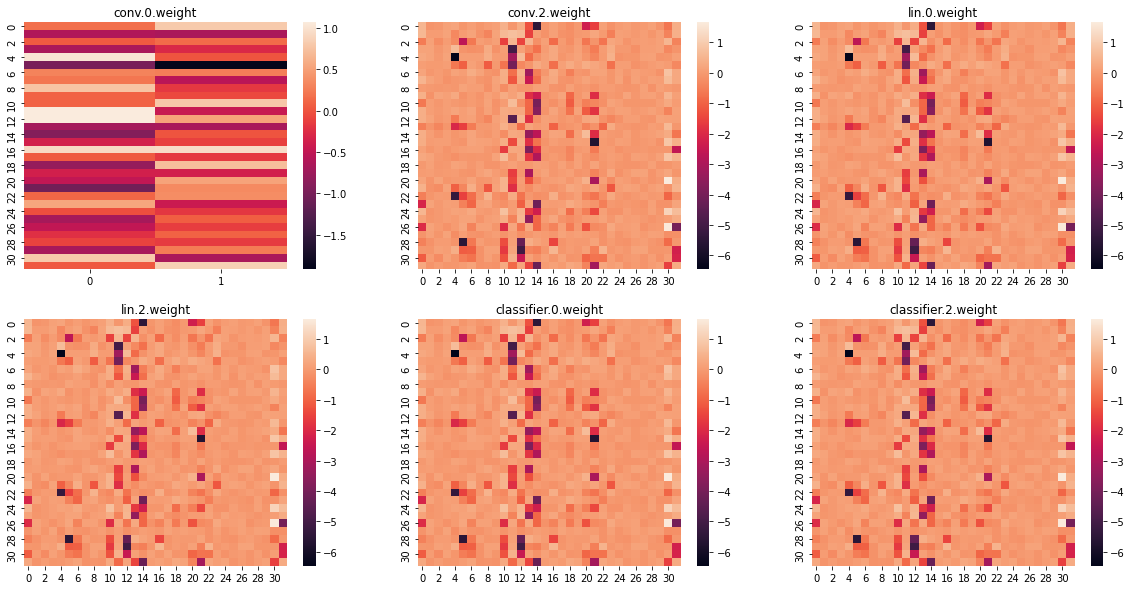

In [16]:
get_weight(miNet)

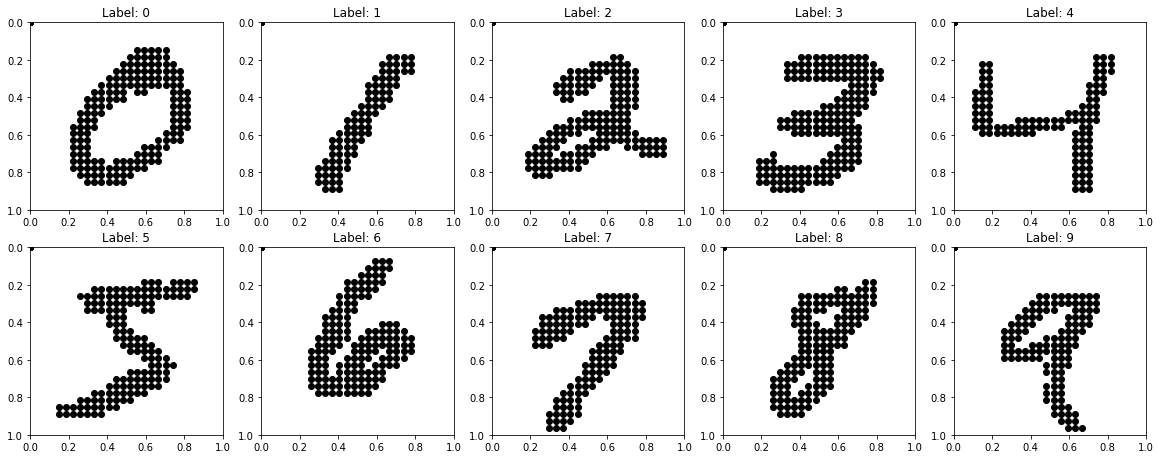

In [17]:
dataset_mnist_set = MNISTSet(full=True)
class_names =   [ 0 , 1 , 2,  3 , 4 , 5 , 6 , 7 ,  8 ,  9]
sampleSet = []
sampleMask = []
for i in range(len(class_names)):
    for j in range(len(dataset_mnist_set)):
        if i == dataset_mnist_set[j][0]:
            sampleSet.append(dataset_mnist_set[j][1])
            sampleMask.append(dataset_mnist_set[j][2])
            break
fig = plt.figure(figsize=(20, 20))

for i,set in enumerate(sampleSet):
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'k')
    plt.axis([0, 1, 1, 0])
    plt.title('Label: {}'.format(i))

2


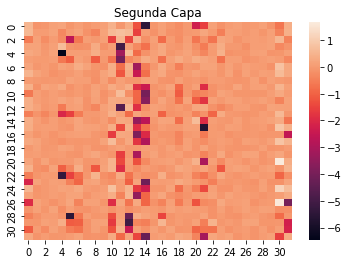

In [18]:
for i ,w in enumerate(miNet.named_parameters()):
    if i % 2 == 0 and i <= 10 and i==2: 
        #plt.subplot(2,3,j) 
        print(i)
        plt.title("Segunda Capa")
        if w[1].size(-1) == 1:
            data = w[1].squeeze(2).detach().numpy()
        sn.heatmap(data, annot=False, fmt='g')
        j+=1
        break
        if i == 10:
            break
plt.show()

In [19]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        pred = miNet(sampleSet[i].unsqueeze(0),sampleMask[i].unsqueeze(0))
        print("We obtained {}, and the expected is: {} with probaility {}".format(np.argmax(pred).item(),class_names[i],pred.max(1)[0].item()))

We obtained 0, and the expected is: 0 with probaility 5.43430233001709
We obtained 1, and the expected is: 1 with probaility 6.19106388092041
We obtained 2, and the expected is: 2 with probaility 13.55985164642334
We obtained 3, and the expected is: 3 with probaility 6.519151210784912
We obtained 4, and the expected is: 4 with probaility 10.252617835998535
We obtained 5, and the expected is: 5 with probaility 10.950203895568848
We obtained 6, and the expected is: 6 with probaility 7.255260467529297
We obtained 7, and the expected is: 7 with probaility 7.08425235748291
We obtained 8, and the expected is: 8 with probaility 5.175957679748535
We obtained 9, and the expected is: 9 with probaility 5.4835100173950195


In [20]:
model1 = MaxEncoder(set_channels,latent_dim,hidden_dim)
model1 = torch.nn.Sequential(*(list(miNet.children())[:-2]))
print(model1)

Sequential(
  (0): Sequential(
    (0): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
)


torch.Size([1, 32])


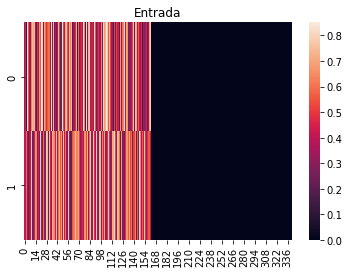

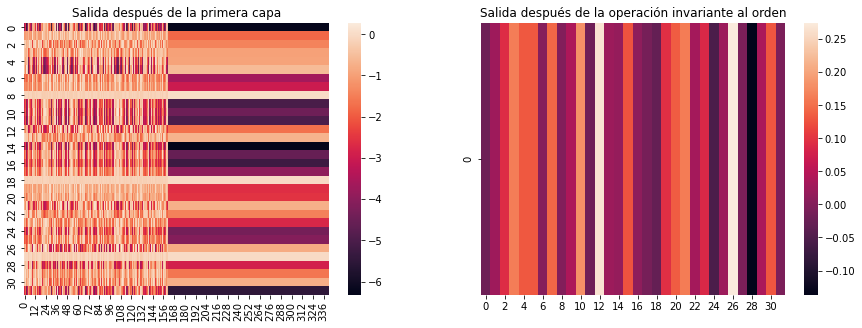

In [23]:
with torch.no_grad():
    data = sampleSet[0]
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Entrada")
    fig, ax = plt.subplots(2, 2, figsize=(15,5))
    plt.subplot(1,2,1) 
    pred = model1(sampleSet[0].unsqueeze(0))
    feature_map = pred
    data = pred.squeeze(0).detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la primera capa")
    plt.subplot(1,2,2) 
    pred = pred.max(2)[0]
    max_map = pred
    print(max_map.shape)
    data = pred.detach().numpy()
    sn.heatmap(data, annot=False, fmt='g')
    plt.title("Salida después de la operación invariante al orden")
    plt.show()

In [24]:
def critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = pred.squeeze(0)
    #print(features_map.shape)
    #Aplicamos la operación invariante max
    xmax = features_map.max(axis=1)[0]
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    rango = len(newxmaxargs)
    for k in range(rango):
        #if not (points[0,newxmaxargs[k]]==0. and points[1,newxmaxargs[k]] ==0.):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])

    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [25]:
crit = dataset_mnist_set[800][1]
s = critical_points_MaxEncoder(model1,crit)
s

array([[0.5185185 , 0.5925926 , 0.9259259 , 0.22222222, 0.6296296 ,
        0.22222222, 0.37037036, 0.9259259 , 0.8148148 , 0.22222222,
        0.4814815 , 0.44444445, 0.7407407 , 0.6666667 , 0.37037036,
        0.6666667 , 0.        ],
       [0.2962963 , 0.6666667 , 0.4814815 , 0.7407407 , 0.33333334,
        0.5185185 , 0.7407407 , 0.5925926 , 0.6296296 , 0.4814815 ,
        0.2962963 , 0.7037037 , 0.6296296 , 0.6296296 , 0.33333334,
        0.37037036, 0.        ]], dtype=float32)

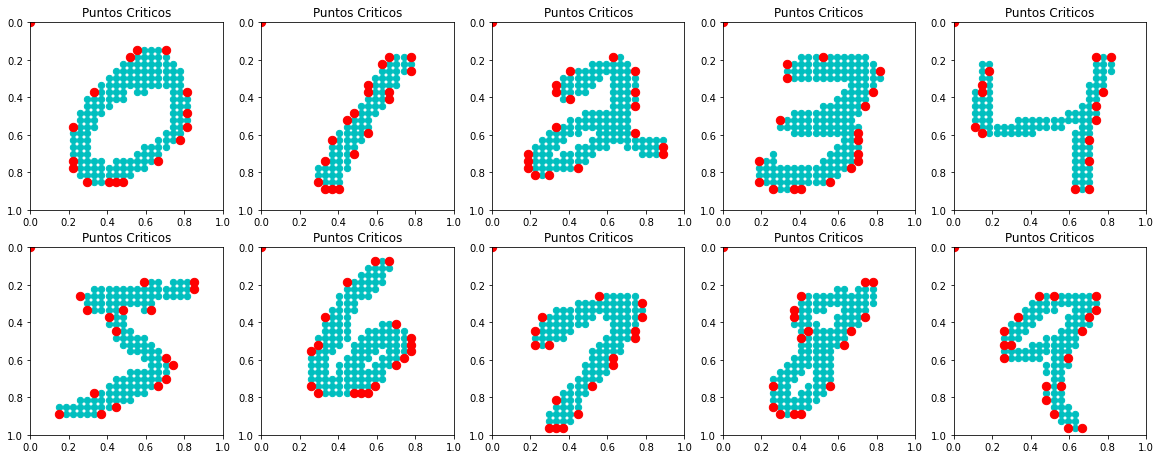

In [26]:
fig = plt.figure(figsize=(20, 20))
for i,set in enumerate(sampleSet):
    crit = critical_points_MaxEncoder(model1,set)
    ax = fig.add_subplot(5, 5, i+1)
    x = set[1, :]
    y = set[0, :]
    plt.scatter(x, y,color = 'c',s=40)
    x = crit[1, :]
    y = crit[0, :]
    plt.scatter(x, y,marker='o',color = 'r',s=70)
    plt.axis([0, 1, 1, 0])
    plt.title('Puntos Criticos')
plt.show()

In [27]:
dataset_mnist_set[3005][0]

3

In [28]:
crit = sampleSet[9]
s = critical_points_MaxEncoder(model1,crit)
st = torch.Tensor(s).unsqueeze(0)
print(st.shape)
muestraSintetica = torch.zeros(1,2,0)
muestraSintetica = torch.cat((st,muestraSintetica,),2)
mask_sintetica = torch.ones(1,st.size(2))
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 2, 19])
torch.Size([1, 2, 19])
torch.Size([1, 19])


tensor([[0.3704, 0.8889, 0.4444, 0.2593, 0.2593, 0.5185, 0.8148, 0.7407, 0.2593,
         0.4444, 0.3333, 0.5185, 0.9630, 0.9630, 0.3704, 0.7407, 0.5926, 0.5926,
         0.0000],
        [0.7037, 0.5185, 0.6667, 0.5185, 0.7407, 0.2593, 0.4815, 0.4815, 0.4444,
         0.2593, 0.7407, 0.2963, 0.6667, 0.5926, 0.3333, 0.5556, 0.2593, 0.5926,
         0.0000]])


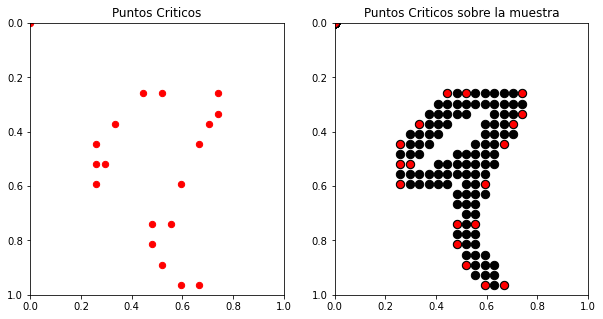

In [29]:
sam = muestraSintetica.squeeze(0)
print(sam)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2,1)
x1 = s[1, :]
y1 = s[0, :]
plt.scatter(x1, y1,c ='r',s=40)
#plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
plt.title('Puntos Criticos')
ax = fig.add_subplot(1, 2,2)
x = crit[1, :]
y = crit[0, :]
plt.scatter(x, y,marker='o',color = 'k',s=70)
plt.axis([0, 1, 1, 0])
plt.title('Puntos Criticos sobre la muestra')
plt.scatter(x1, y1,marker='o',color ='r')
plt.show()

## Comparación de las predicciones

In [47]:
same = 0
not_same = 0
for i, sample in enumerate(dataset_mnist_set):
    s = critical_points_MaxEncoder(model1,sample[1])
    st = torch.Tensor(s).unsqueeze(0)
    pred = miNet(muestraSintetica,mask_sintetica)
    muestraSintetica = torch.zeros(1,2,0)
    muestraSintetica = torch.cat((st,muestraSintetica,),2)
    mask_sintetica = torch.ones(1,st.size(2))
    predMax = miNet(muestraSintetica,mask_sintetica)
    pred = miNet(sample[1].unsqueeze(0),sample[2].unsqueeze(0))
    if (torch.eq(predMax,pred).sum())==pred.size(1)  :
        same+=1
    else:
        not_same+=1
print("Aciertos: ",same)
print("Falladis: ",not_same)

Aciertos:  60000
Falladis:  0


In [30]:
with torch.no_grad():
    pred = miNet(muestraSintetica,mask_sintetica)
    print(muestraSintetica.shape)
    print(mask_sintetica.shape)
    print("We obtained {}, and the expected is: {}".format(np.argmax(pred).item(),9))
    predReal= miNet(crit.unsqueeze(0),dataset_mnist_set[3005][1])
    print(pred)
    print(predReal)

torch.Size([1, 2, 19])
torch.Size([1, 19])
We obtained 9, and the expected is: 9
tensor([[-13.3470,  -2.1836,  -5.2066,  -3.0497,   2.8636,  -2.8914, -19.3753,
           1.6359,  -1.0434,   5.4835]])
tensor([[-13.3470,  -2.1836,  -5.2066,  -3.0497,   2.8636,  -2.8914, -19.3753,
           1.6359,  -1.0434,   5.4835]])


In [173]:
with torch.no_grad():
    for i in range(len(sampleSet)):
        #Preparacion de la muestra sintetica
        crit = sampleSet[i]
        s = critical_points_MaxEncoder(model1,crit)
        st = torch.Tensor(s).unsqueeze(0)
        muestraSintetica = torch.zeros(1,2,0)
        muestraSintetica = torch.cat((st,muestraSintetica,),2)
        mask_sintetica = torch.ones(1,st.size(2))
        #Prediccion de la red con la muestra
        pred = miNet(muestraSintetica,mask_sintetica)
        predReal= miNet(crit.unsqueeze(0),sampleMask[i].unsqueeze(0))
        print()
        print("We obtained {}, and the expected is: {}, with this trust {}, vs the real one: {}".format(np.argmax(pred).item(), class_names[i],round(pred.max().item(),2),round(predReal.max().item(),2)))
        


We obtained 0, and the expected is: 0, with this trust 5.43, vs the real one: 5.43

We obtained 1, and the expected is: 1, with this trust 6.19, vs the real one: 6.19

We obtained 2, and the expected is: 2, with this trust 13.56, vs the real one: 13.56

We obtained 3, and the expected is: 3, with this trust 6.52, vs the real one: 6.52

We obtained 4, and the expected is: 4, with this trust 10.25, vs the real one: 10.25

We obtained 5, and the expected is: 5, with this trust 10.95, vs the real one: 10.95

We obtained 6, and the expected is: 6, with this trust 7.26, vs the real one: 7.26

We obtained 7, and the expected is: 7, with this trust 7.08, vs the real one: 7.08

We obtained 8, and the expected is: 8, with this trust 5.18, vs the real one: 5.18

We obtained 9, and the expected is: 9, with this trust 5.48, vs the real one: 5.48


## Otro experimento

In [174]:

def not_critical_points_MaxEncoder(model, sample):
    critical_points_y = []
    critical_points_x = []
    #Salida de la capa de convoluciones
    pred = model(sample.unsqueeze(0))
    features_map = abs(pred.squeeze(0))
    xsort,_ = torch.sort(features_map,descending=True)
    #print(xsort)
    xsortargs = torch.argsort(features_map,descending=True)
    #print(xsortargs[0][:][0])
    
    #xmax = features_map.max(axis=1)[0]
    #xmax,_ = torch.sort(xmax,descending=True)
    #print(xmax.shape)
    xmaxargs = features_map.argmax(axis=1)
    xmaxargs,_ = torch.sort(xmaxargs,descending=False)
    #No nos quedamos con las coordenadas repetidas
    newxmaxargs = np.unique(xmaxargs)
    xmin = features_map.min(axis=1)[0]
    #print(xmax.shape)
    xminargs = features_map.argmin(axis=1)
    #No nos quedamos con las coordenadas repetidas
    newxminargs = np.unique(xminargs)
    points = sample.numpy()
    '''
    critical = np.zeros(342)
    for f in range(32):
        for p in range(342):
            if features_map[f,p] == xmax[f]:
                critical[p] =critical[p]+1
    sorted_critical = np.sort(-critical)
    sorted_critical_args = -np.argsort(-critical)
    print(sorted_critical_args*-1)
    '''
    '''
        Vamos a probar cogiendo los 2 primeros maximos
    
    #print(features_map.shape)
    xsort,_ = torch.sort(features_map,descending=True)
    xsortargs= torch.argsort(features_map,descending=True)
    xsum = features_map.sum(1)
    print(xsortargs.shape)
    #print(xsortargs.shape)
    
    for i,tensor in enumerate(features_map):
        suma = 0
        z = 0
        #print(tensor.shape)
        while(suma<(xsum[i]*0.3) and z < 10):
            #print(xsortargs[z].shape)
            suma+= features_map[i][z]
            critical_points_y.append(points[0,xsortargs[i][z]])
            critical_points_x.append(points[1,xsortargs[i][z]])
            z += 1
            
    '''
    '''
    for k in range(len(newxmaxargs)):
        critical_points_y.append(points[0,newxmaxargs[k]])
        critical_points_x.append(points[1,newxmaxargs[k]])
    
    for k in range(len(newxminargs)):
        critical_points_y.append(points[0,newxminargs[k]])
        critical_points_x.append(points[1,newxminargs[k]])
    '''
    guardados = []
    for j in range(5):
        for i in range(32):
            if xsortargs[i][:][j] not in guardados and not (points[0,xsortargs[i][:][j]]==0. and points[1,xsortargs[i][:][j]] ==0.):
                critical_points_y.append(points[0,xsortargs[i][:][j]])
                critical_points_x.append(points[1,xsortargs[i][:][j]])
                guardados.append(xsortargs[i][:][j])
                '''
                else:
                    
                    critical_points_y.append(points[0,xsortargs[i][:][j]])
                    critical_points_x.append(points[1,xsortargs[i][:][j]])
                    #print(xsort[i][:][j])
                    guardados.append(xsortargs[i][:][j])
                '''
            
    #print(len(critical_points_x))
    x = np.array(critical_points_x)
    y = np.array(critical_points_y)
    s = np.stack((y,x))
    return s 

In [175]:
crit = sampleSet[9]
s = not_critical_points_MaxEncoder(model1,crit)
st = torch.Tensor(s).unsqueeze(0)
print(st.shape)
muestraSintetica = torch.zeros(1,2,0)
muestraSintetica = torch.cat((st,muestraSintetica,),2)
mask_sintetica = torch.ones(1,st.size(2))
print(muestraSintetica.shape)
print(mask_sintetica.shape)

torch.Size([1, 2, 18])
torch.Size([1, 2, 18])
torch.Size([1, 18])


tensor([[0.9630, 0.9630, 0.4074, 0.2593, 0.9630, 0.9259, 0.4444, 0.2963, 0.9259,
         0.3704, 0.3333, 0.8889, 0.8889, 0.4074, 0.2593, 0.9259, 0.3704, 0.2963],
        [0.6667, 0.5926, 0.7037, 0.7407, 0.6296, 0.5556, 0.6667, 0.7407, 0.6296,
         0.7037, 0.7407, 0.6296, 0.5185, 0.6667, 0.7037, 0.5926, 0.6667, 0.7037]])


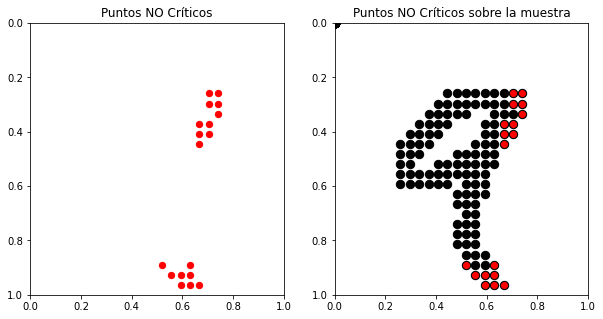

In [176]:
sam = muestraSintetica.squeeze(0)
print(sam)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2,1)
x1 = s[1, :]
y1 = s[0, :]
plt.scatter(x1, y1,c ='r',s=40)
#plt.scatter(x1, y1,marker='x',color ='r')
plt.axis([0, 1, 1, 0])
plt.title('Puntos NO Críticos')
ax = fig.add_subplot(1, 2,2)
x = crit[1, :]
y = crit[0, :]
plt.scatter(x, y,marker='o',color = 'k',s=70)
plt.axis([0, 1, 1, 0])
plt.title('Puntos NO Críticos sobre la muestra')
plt.scatter(x1, y1,marker='o',color ='r')
plt.show()